In [1]:
%matplotlib inline
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('font', family='Verdana')

import scipy.stats as stats

from scipy.cluster.hierarchy import *
from scipy.spatial.distance import *

from sklearn.cluster import KMeans

from sklearn.manifold import MDS
from sklearn.manifold import Isomap

from sklearn import linear_model as lm
import itertools

In [2]:
# Так как нужно обрабатывать данные из нескольких наборов, 
# заведу структуру, для совместного хранения даннных одного этапа обработки
class DataSets:
    def __init__(self):
        self.Ohta = None
        self.Bel = None
        self.Lex = None
    
    def to_csv(self, name_pref):
        self.Ohta.to_csv(path_or_buf = name_pref + '_ohta.csv')
        self.Bel.to_csv(path_or_buf = name_pref + '_bel.csv')
        self.Lex.to_csv(path_or_buf = name_pref + '_lex.csv')

In [3]:
raw = DataSets()

raw.Ohta = pd.read_csv('cluster_data/contractor_ohta.csv', engine = 'c')
raw.Bel = pd.read_csv('cluster_data/contractor_bel.csv', engine = 'c')
raw.Lex = pd.read_csv('cluster_data/contractor_lex.csv', engine = 'c')

In [4]:
raw.Ohta = raw.Ohta[~pd.isnull(raw.Ohta['contractor_code'])]
raw.Bel = raw.Bel[~pd.isnull(raw.Bel['contractor_code'])]
raw.Lex = raw.Lex[~pd.isnull(raw.Lex['contractor_code'])]

In [5]:
l = lambda x: int(x)

raw.Ohta['contractor_code'] = raw.Ohta['contractor_code'].apply(l)
raw.Bel['contractor_code'] = raw.Bel['contractor_code'].apply(l)
raw.Lex['contractor_code'] = raw.Lex['contractor_code'].apply(l)

raw.Ohta.set_index('contractor_code', inplace = True)
raw.Bel.set_index('contractor_code', inplace = True)
raw.Lex.set_index('contractor_code', inplace = True)

In [6]:
d = DataSets()

d.Ohta = raw.Ohta.copy()
d.Bel = raw.Bel.copy()
d.Lex = raw.Lex.copy()

# Шкалирования данных

In [7]:
l1 = lambda x: 0.0 if pd.isnull(x) else x
l2 = lambda col: col.apply(l1)

d.Ohta = d.Ohta.apply(l2)
d.Bel = d.Bel.apply(l2)
d.Lex = d.Lex.apply(l2)

In [8]:
var_lst = ['sales_count', 'mean_cost', 'duration', 'operation_freq', 'event_freq']

In [9]:
clust = DataSets()

l1 = lambda x, mean, std: (x-mean)/std if std != 0.0 else 0.0
l2 = lambda col: col.apply(l1, args=(np.mean(col), np.std(col)))

clust.Ohta = d.Ohta.apply(l2)
clust.Bel = d.Bel.apply(l2)
clust.Lex = d.Lex.apply(l2)

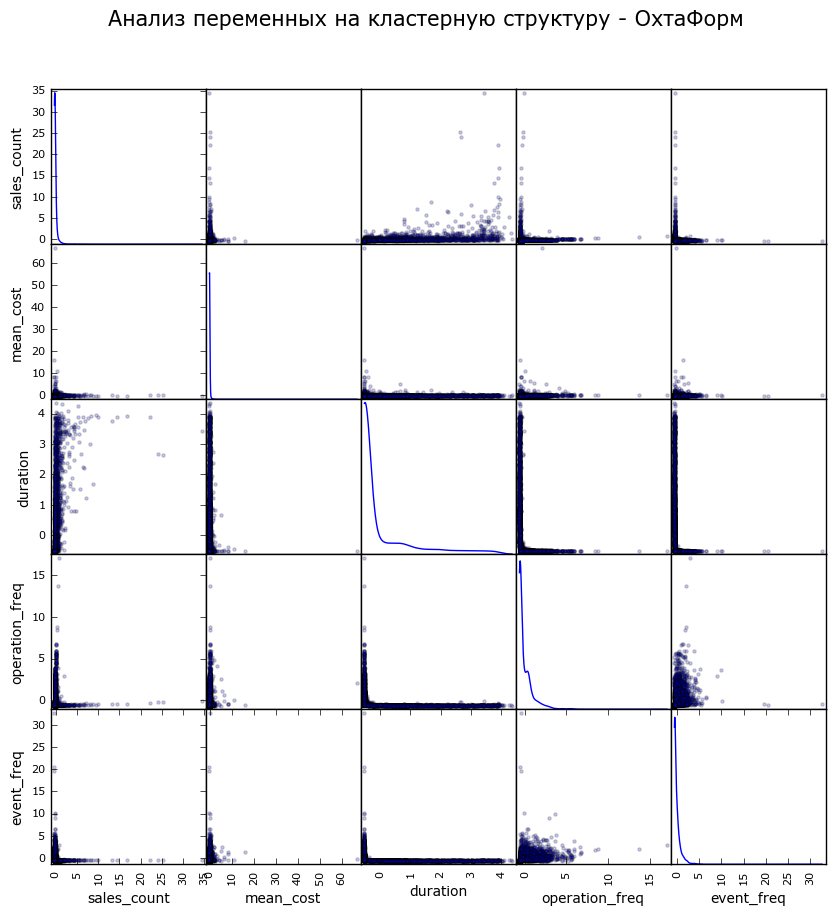

In [10]:
pd.scatter_matrix(clust.Ohta[var_lst], alpha=0.2, figsize=(10, 10), diagonal='kde')

plt.suptitle('Анализ переменных на кластерную структуру - ОхтаФорм', fontsize = 15)
#plt.tight_layout()
plt.show()

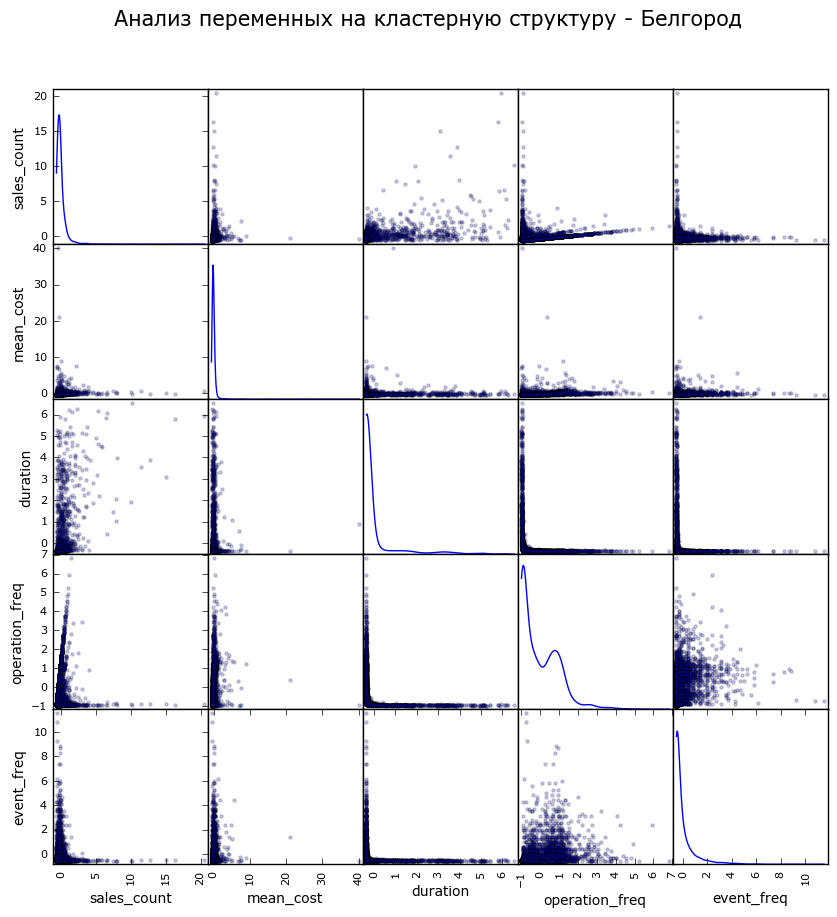

In [11]:
pd.scatter_matrix(clust.Bel[var_lst], alpha=0.2, figsize=(10, 10), diagonal='kde')

plt.suptitle('Анализ переменных на кластерную структуру - Белгород', fontsize = 15)
plt.show()

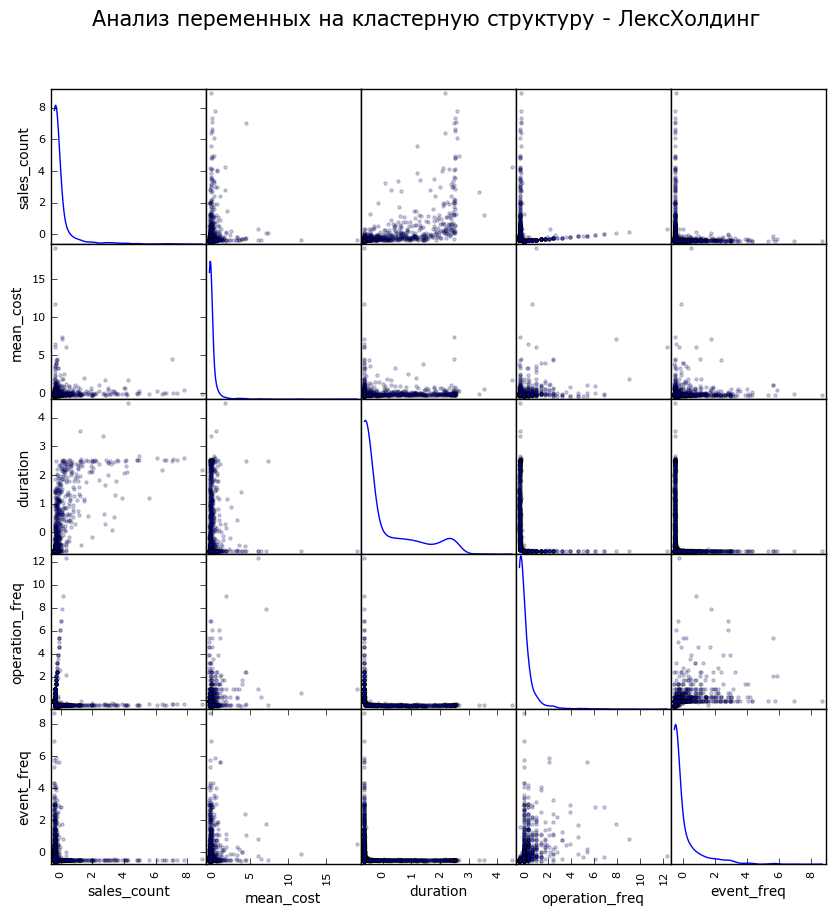

In [12]:
pd.scatter_matrix(clust.Lex[var_lst], alpha=0.2, figsize=(10, 10), diagonal='kde')

plt.suptitle('Анализ переменных на кластерную структуру - ЛексХолдинг', fontsize = 15)
plt.show()

In [13]:
def kmeans_ss(km, dat):
    res = .0
    for label in np.arange(0, km.n_clusters):
        center = km.cluster_centers_[label]
        c = dat[dat['group_no'] == label]
        res += sum(sum((c.values[:,0:3] - center)**2))
    return res

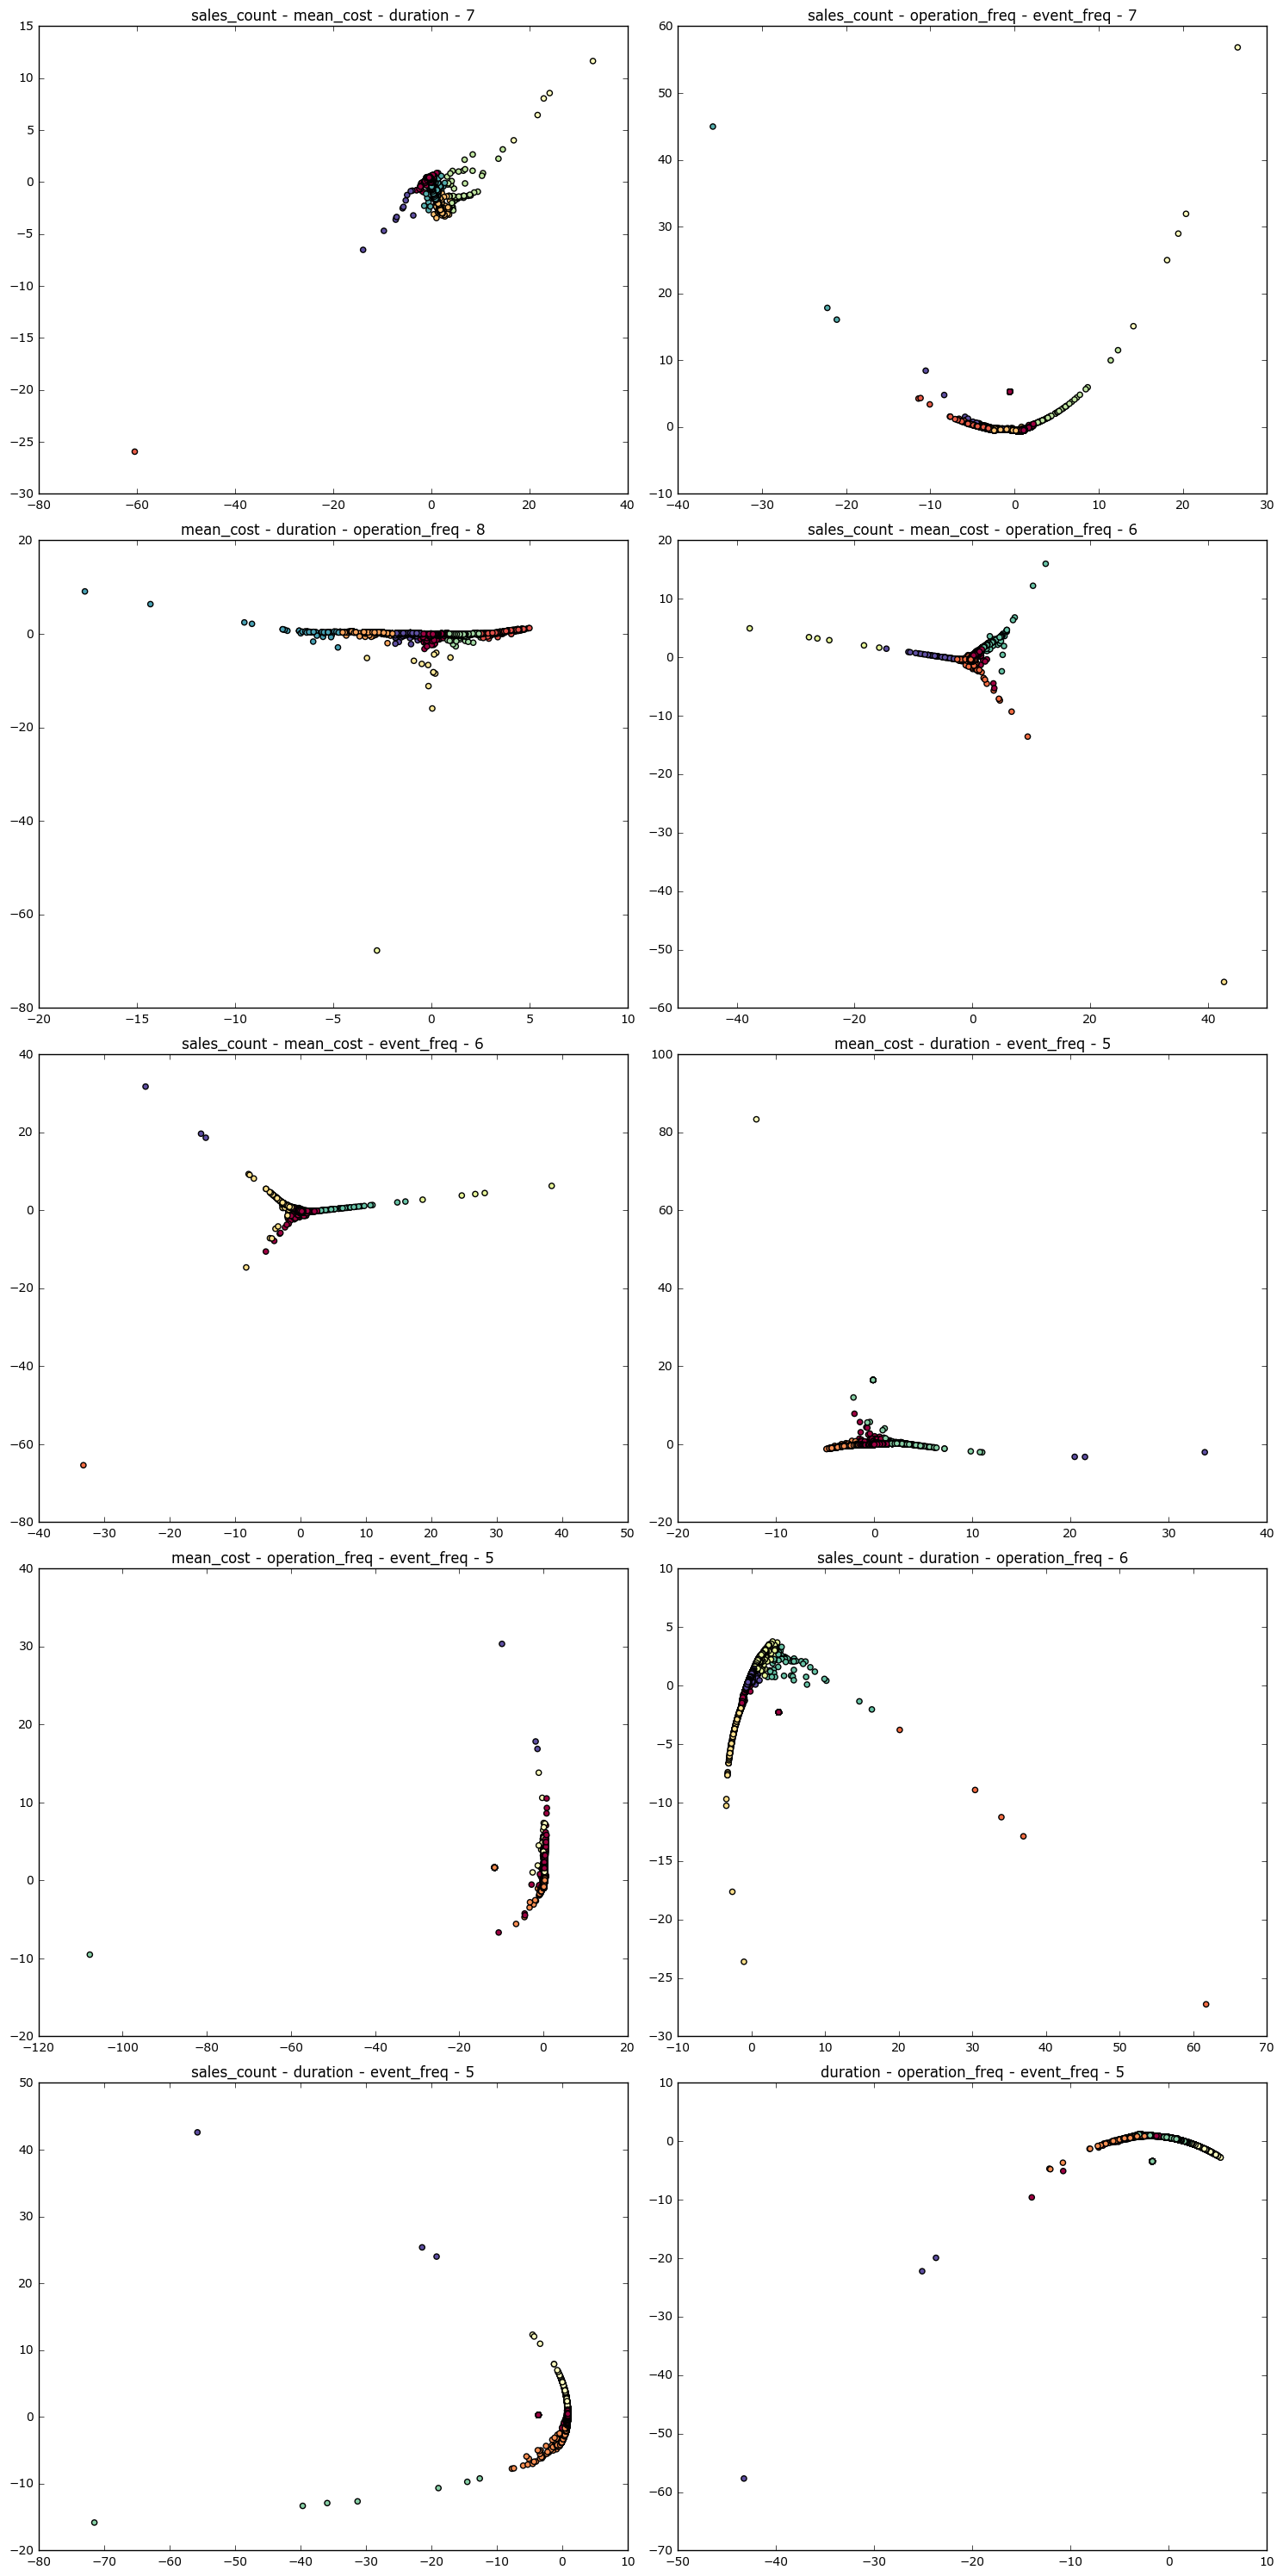

In [14]:
d = clust.Ohta[['sales_count', 'mean_cost', 'duration', 'operation_freq', 'event_freq']]
nc_min = 4
nc_max = 12

cols = list(d.columns)
product_res = list(itertools.combinations(cols, r=3))

fig, axarr = plt.subplots(5, 2)
fig.set_size_inches(15, 30)

ax_iter = 0

for pair in product_res:
    cset = d[[pair[0], pair[1], pair[2]]].copy()
    ax = axarr[ax_iter % 5, ax_iter % 2]
    ax_iter += 1
    
    prev_val = 0.000000001
    record_val = 0
    n_clust_record = 0
    
    for nc in np.arange(nc_min, nc_max):
        
        kmeans_estimator = KMeans(n_clusters = nc,  
                                  precompute_distances = True,
                                  max_iter = 1000,
                                  tol = .000001, 
                                  n_jobs = 4)
        
        kmeans_estimator.fit(cset.values)
        cset['group_no'] = kmeans_estimator.labels_
        
        elbow_val = kmeans_ss(kmeans_estimator, cset)
        
        del cset['group_no']
        
        n_clust_record = nc if record_val < prev_val/elbow_val else n_clust_record
        record_val = prev_val/elbow_val if record_val < prev_val/elbow_val else record_val
        prev_val = elbow_val
    
    
    kmeans_estimator = KMeans(n_clusters = n_clust_record,  
                                  precompute_distances = True,
                                  max_iter = 1000,
                                  tol = .000001, 
                                  n_jobs = 4)
    
    kmeans_estimator.fit(cset.values)
    res_set = cset.copy()
    res_set['group_no'] = kmeans_estimator.labels_
    
    #mds = MDS(2, max_iter = 20, n_init = 1, n_jobs = 4)
    isomap = Isomap(10, n_components=2)
    trans_data = isomap.fit_transform(cset.values).T
    
    ax.scatter(trans_data[0], trans_data[1], c=res_set['group_no'], cmap=plt.cm.Spectral)
    ax.set_title(str(pair[0]) + ' - ' + str(pair[1]) + ' - ' +  str(pair[2]) + ' - ' + str(n_clust_record))
    
plt.tight_layout()
plt.show()

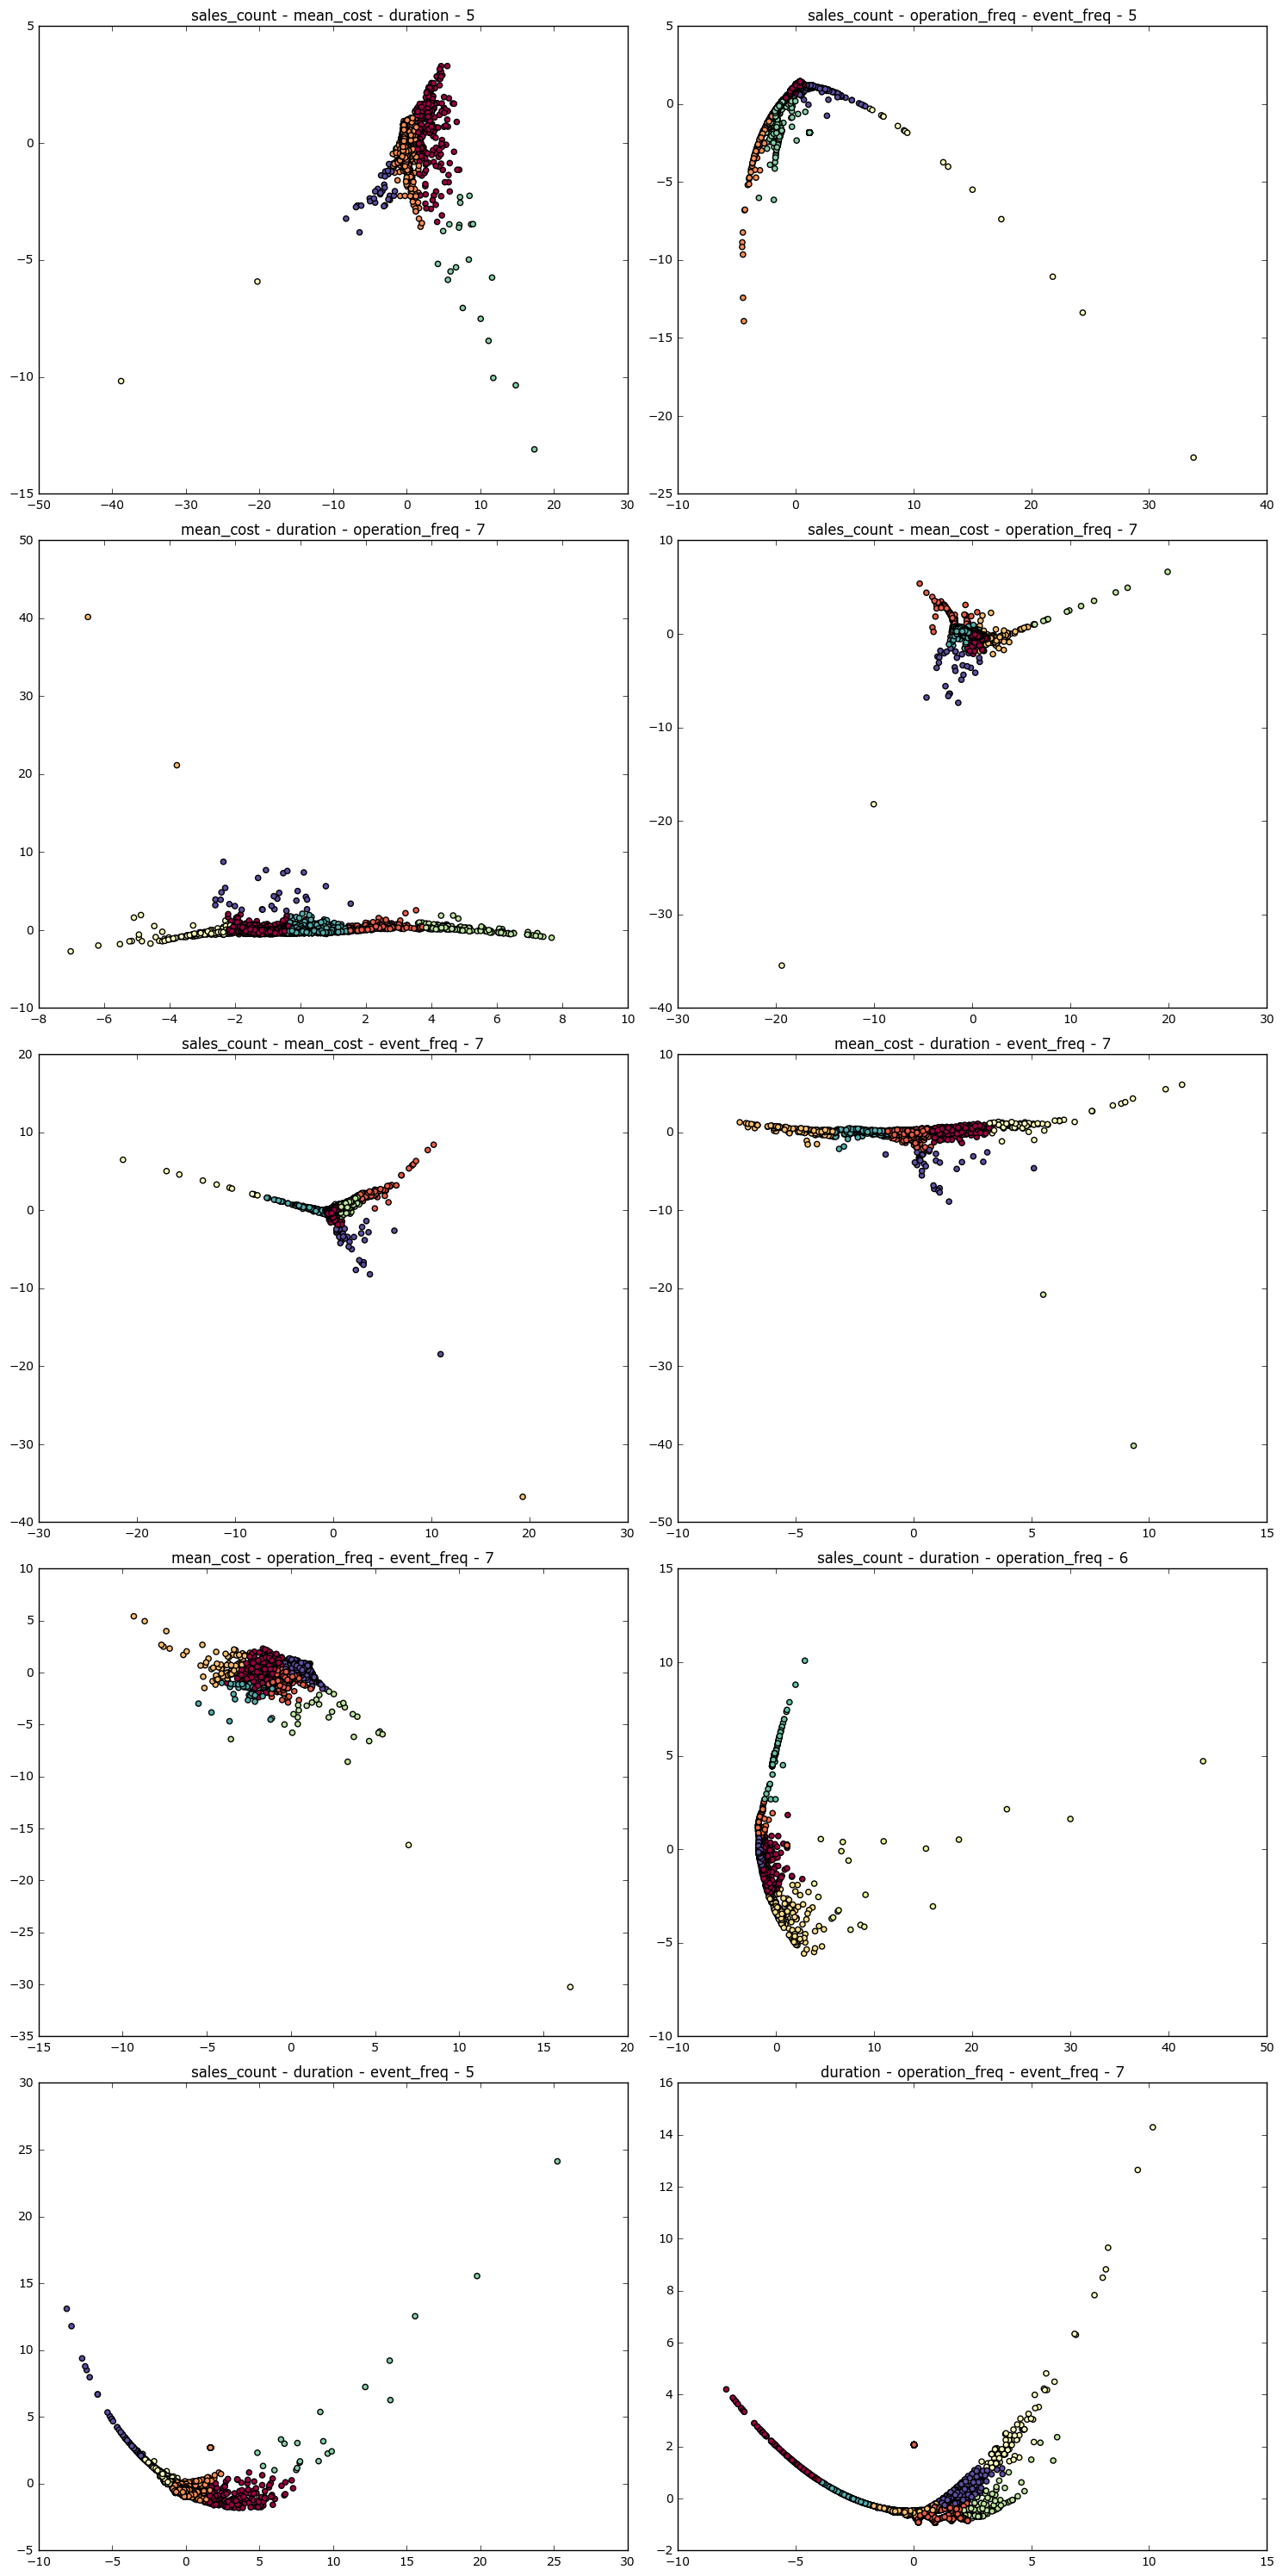

In [15]:
d = clust.Bel[['sales_count', 'mean_cost', 'duration', 'operation_freq', 'event_freq']]
nc_min = 4
nc_max = 12

cols = list(d.columns)
product_res = list(itertools.combinations(cols, r=3))

fig, axarr = plt.subplots(5, 2)
fig.set_size_inches(15, 30)

ax_iter = 0

for pair in product_res:
    cset = d[[pair[0], pair[1], pair[2]]].copy()
    ax = axarr[ax_iter % 5, ax_iter % 2]
    ax_iter += 1
    
    prev_val = 0.000000001
    record_val = 0
    n_clust_record = 0
    
    for nc in np.arange(nc_min, nc_max):
        
        kmeans_estimator = KMeans(n_clusters = nc,  
                                  precompute_distances = True,
                                  max_iter = 1000,
                                  tol = .000001, 
                                  n_jobs = 4)
        
        kmeans_estimator.fit(cset.values)
        cset['group_no'] = kmeans_estimator.labels_
        
        elbow_val = kmeans_ss(kmeans_estimator, cset)
        
        del cset['group_no']
        
        n_clust_record = nc if record_val < prev_val/elbow_val else n_clust_record
        record_val = prev_val/elbow_val if record_val < prev_val/elbow_val else record_val
        prev_val = elbow_val
    
    
    kmeans_estimator = KMeans(n_clusters = n_clust_record,  
                                  precompute_distances = True,
                                  max_iter = 1000,
                                  tol = .000001, 
                                  n_jobs = 4)
    
    kmeans_estimator.fit(cset.values)
    res_set = cset.copy()
    res_set['group_no'] = kmeans_estimator.labels_
    
    #mds = MDS(2, max_iter = 20, n_init = 1, n_jobs = 4)
    isomap = Isomap(10, n_components=2)
    trans_data = isomap.fit_transform(cset.values).T
    
    ax.scatter(trans_data[0], trans_data[1], c=res_set['group_no'], cmap=plt.cm.Spectral)
    ax.set_title(str(pair[0]) + ' - ' + str(pair[1]) + ' - ' +  str(pair[2]) + ' - ' + str(n_clust_record))
    
plt.tight_layout()
plt.show()

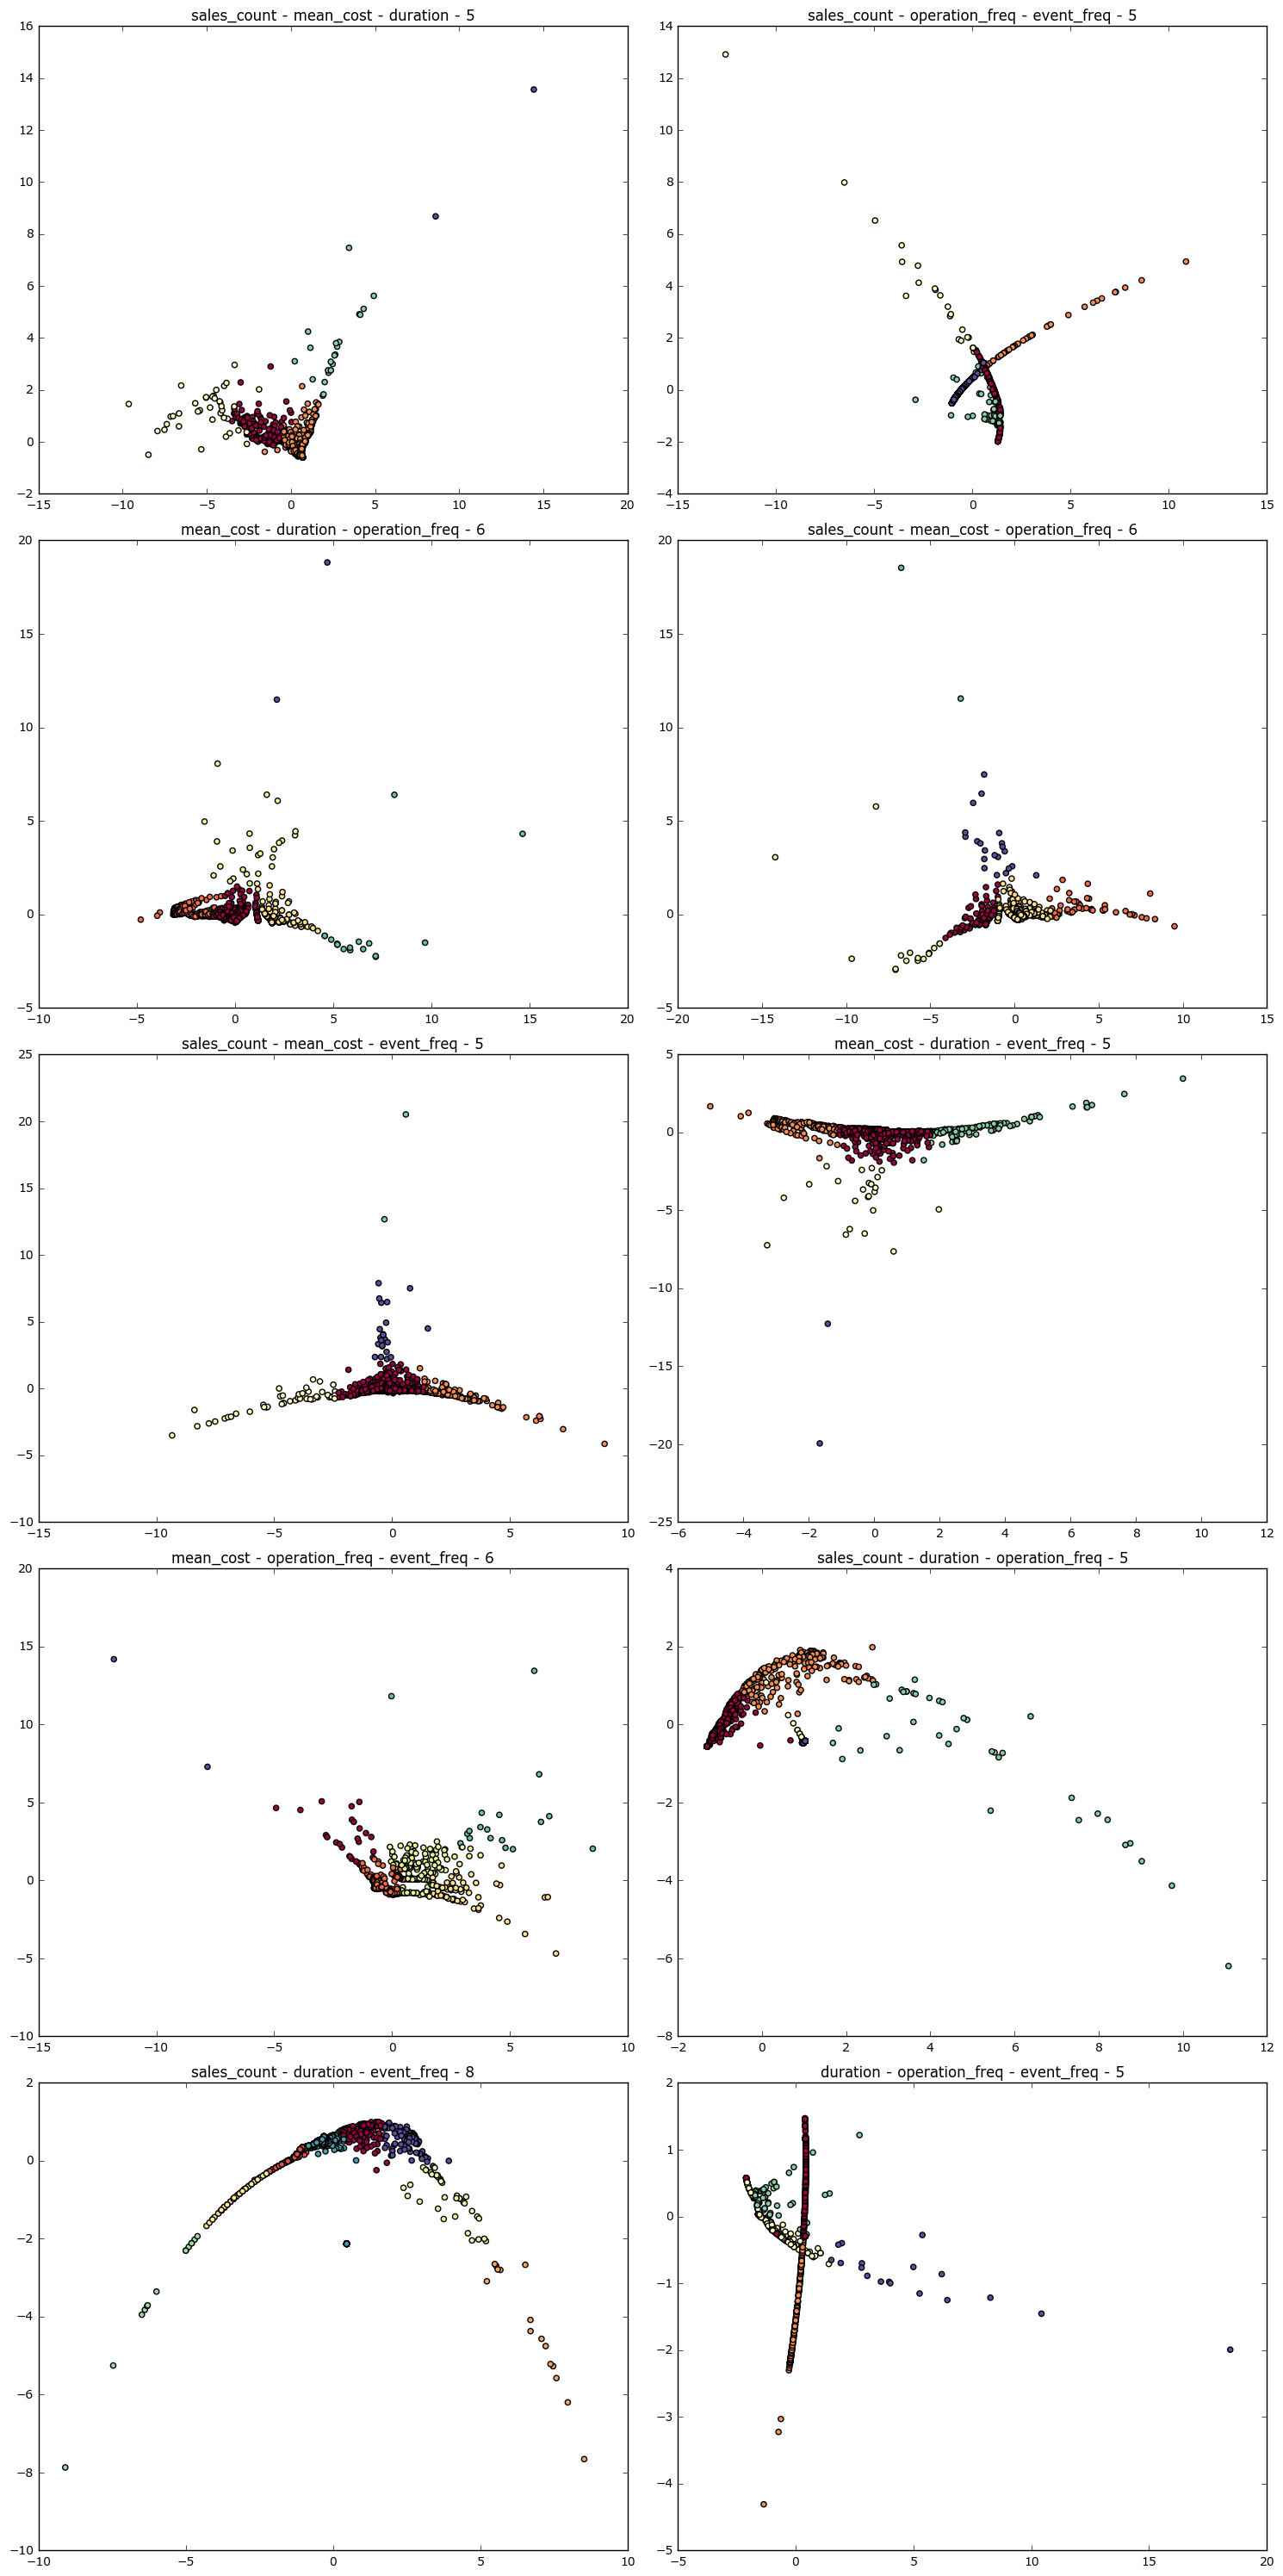

In [16]:
d = clust.Lex[['sales_count', 'mean_cost', 'duration', 'operation_freq', 'event_freq']]
nc_min = 4
nc_max = 12

cols = list(d.columns)
product_res = list(itertools.combinations(cols, r=3))

fig, axarr = plt.subplots(5, 2)
fig.set_size_inches(15, 30)

ax_iter = 0

for pair in product_res:
    cset = d[[pair[0], pair[1], pair[2]]].copy()
    ax = axarr[ax_iter % 5, ax_iter % 2]
    ax_iter += 1
    
    prev_val = 0.000000001
    record_val = 0
    n_clust_record = 0
    
    for nc in np.arange(nc_min, nc_max):
        
        kmeans_estimator = KMeans(n_clusters = nc,  
                                  precompute_distances = True,
                                  max_iter = 1000,
                                  tol = .000001, 
                                  n_jobs = 4)
        
        kmeans_estimator.fit(cset.values)
        cset['group_no'] = kmeans_estimator.labels_
        
        elbow_val = kmeans_ss(kmeans_estimator, cset)
        
        del cset['group_no']
        
        n_clust_record = nc if record_val < prev_val/elbow_val else n_clust_record
        record_val = prev_val/elbow_val if record_val < prev_val/elbow_val else record_val
        prev_val = elbow_val
    
    
    kmeans_estimator = KMeans(n_clusters = n_clust_record,  
                                  precompute_distances = True,
                                  max_iter = 1000,
                                  tol = .000001, 
                                  n_jobs = 4)
    
    kmeans_estimator.fit(cset.values)
    res_set = cset.copy()
    res_set['group_no'] = kmeans_estimator.labels_
    
    #mds = MDS(2, max_iter = 20, n_init = 1, n_jobs = 4)
    isomap = Isomap(10, n_components=2)
    trans_data = isomap.fit_transform(cset.values).T
    
    ax.scatter(trans_data[0], trans_data[1], c=res_set['group_no'], cmap=plt.cm.Spectral)
    ax.set_title(str(pair[0]) + ' - ' + str(pair[1]) + ' - ' +  str(pair[2]) + ' - ' + str(n_clust_record))
    
plt.tight_layout()
plt.show()

In [10]:
res = DataSets()
res_lst = ['sales_count', 'mean_cost', 'duration', 'operation_freq']

res.Ohta = clust.Ohta[res_lst].copy()
res.Bel = clust.Bel[res_lst].copy()
res.Lex = clust.Lex[res_lst].copy()

In [41]:
km = KMeans(n_clusters = 7,  
            precompute_distances = True,
            max_iter = 5000,
            tol = .000001, 
            n_jobs = 4,
            random_state = 1000)
km.fit(res.Ohta.values)

res.Ohta['group_no'] = km.labels_

km = KMeans(n_clusters = 7,  
            precompute_distances = True,
            max_iter = 5000,
            tol = .000001, 
            n_jobs = 4,
            random_state = 1000)
km.fit(res.Bel.values)

res.Bel['group_no'] = km.labels_

km = KMeans(n_clusters = 7,  
            precompute_distances = True,
            max_iter = 5000,
            tol = .000001, 
            n_jobs = 4,
            random_state = 0)
km.fit(res.Lex.values)

res.Lex['group_no'] = km.labels_

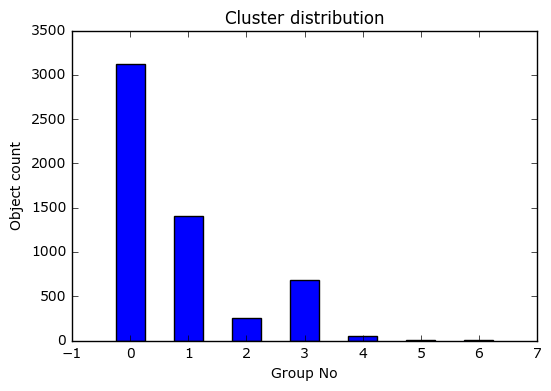

In [20]:
gr = res.Ohta.groupby('group_no').agg(len)
plt.bar(gr.index - 0.25, gr['sales_count'], width = 0.5)
plt.title('Cluster distribution')
plt.xlabel('Group No')
plt.ylabel('Object count')

plt.show()

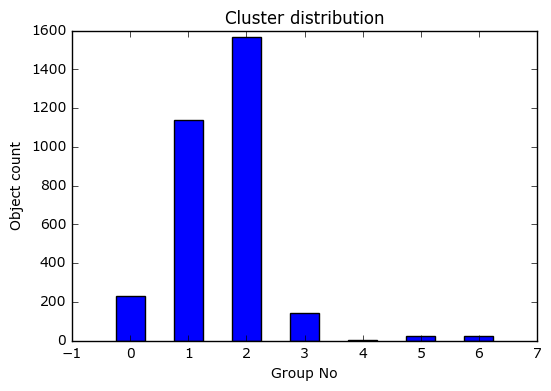

In [21]:
gr = res.Bel.groupby('group_no').agg(len)
plt.bar(gr.index - 0.25, gr['sales_count'], width = 0.5)
plt.title('Cluster distribution')
plt.xlabel('Group No')
plt.ylabel('Object count')

plt.show()

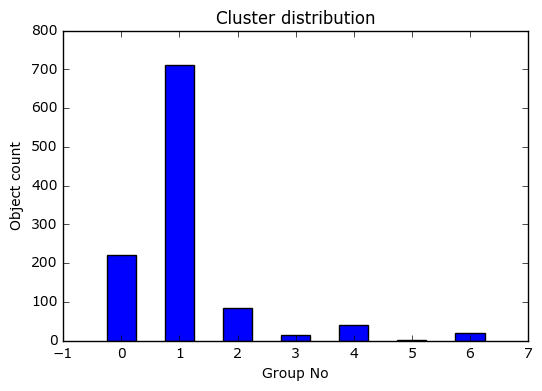

In [22]:
gr = res.Lex.groupby('group_no').agg(len)
plt.bar(gr.index - 0.25, gr['sales_count'], width = 0.5)
plt.title('Cluster distribution')
plt.xlabel('Group No')
plt.ylabel('Object count')

plt.show()

In [42]:
fr = DataSets()

len(km.labels_)
lst = ['sales_count_y', 'mean_cost_y', 'duration_y', 'operation_freq_y', 'group_no']
fr.Ohta = res.Ohta.merge(raw.Ohta, left_index = True, right_index = True, how = 'inner')[lst].copy()
fr.Bel = res.Bel.merge(raw.Bel, left_index = True, right_index = True, how = 'inner')[lst].copy()
fr.Lex = res.Lex.merge(raw.Lex, left_index = True, right_index = True, how = 'inner')[lst].copy()

In [24]:
data = fr.Ohta 
res_df = pd.DataFrame(data = {'1. Количество покупок': [], 
                                  '2. Средняя стоимость чека': [], 
                                  '3. Продолжительность сотрудничества': [], 
                                  '4. Количество операций в день': [],
                                  '5. Количество клиентов в кластере': []})


for i in data['group_no'].drop_duplicates().values:
    
    ss = data[data['group_no'] == i]
    res_df.loc[i] = [np.mean(ss['sales_count_y']), 
                     np.mean(ss['mean_cost_y']),
                     np.mean(ss['duration_y']), 
                     np.mean(ss['operation_freq_y']), 
                     len(ss)]
    
res_df

,1. Количество покупок,2. Средняя стоимость чека,3. Продолжительность сотрудничества,4. Количество операций в день,5. Количество клиентов в кластере
1,16.169034,1.592634e+05,1.288352,12.953694,1408.0
3,98.878832,1.907828e+05,823.948905,0.129635,685.0
0,22.332480,2.360994e+05,73.355200,1.991524,3125.0
4,927.352941,1.880193e+05,1061.588235,0.952491,51.0
2,41.596000,3.838186e+05,1.136000,37.270667,250.0
6,4081.400000,6.104594e+04,1162.200000,3.621281,5.0
5,26.000000,1.681170e+08,1.000000,26.000000,1.0


In [35]:
for_save = DataSets()

pdf = pd.DataFrame(data = {'l_group_no': [1,3,0,4,6,2,5], 
                  'r_group_no': [6,0,1,4,5,2,3]})

lst = ['sales_count_y', 
       'mean_cost_y', 
       'duration_y', 
       'operation_freq_y', 
       'r_group_no']
for_save.Ohta = fr.Ohta.merge(pdf, 
                              left_on = 'group_no', 
                              right_on = 'l_group_no')[lst]

In [17]:
data = fr.Bel 
res_df = pd.DataFrame(data = {'1. Количество покупок': [], 
                                  '2. Средняя стоимость чека': [], 
                                  '3. Продолжительность сотрудничества': [], 
                                  '4. Количество операций в день': [],
                                  '5. Количество клиентов в кластере': []})


for i in data['group_no'].drop_duplicates().values:
    
    ss = data[data['group_no'] == i]
    res_df.loc[i] = [np.mean(ss['sales_count_y']), 
                     np.mean(ss['mean_cost_y']),
                     np.mean(ss['duration_y']), 
                     np.mean(ss['operation_freq_y']), 
                     len(ss)]
    
res_df

,1. Количество покупок,2. Средняя стоимость чека,3. Продолжительность сотрудничества,4. Количество операций в день,5. Количество клиентов в кластере
1,70.534483,1.061399e+05,641.568966,0.129717,232.0
0,22.720945,7.169903e+04,33.956577,4.282426,1566.0
4,452.428571,1.346585e+05,831.095238,0.710156,21.0
2,54.937500,1.603091e+05,1.201389,47.942554,144.0
6,25.913732,1.380219e+05,1.158451,23.099748,1136.0
3,33.434783,1.558789e+06,31.478261,15.401878,23.0
5,14.000000,1.013411e+07,241.000000,0.058091,1.0


In [36]:
pdf = pd.DataFrame(data = {'l_group_no': [1,0,4,2,6,3,5], 
                           'r_group_no': [4,0,3,1,2,6,5]})

lst = ['sales_count_y', 
       'mean_cost_y', 
       'duration_y', 
       'operation_freq_y', 
       'r_group_no']
for_save.Bel = fr.Bel.merge(pdf, 
                              left_on = 'group_no', 
                              right_on = 'l_group_no')[lst]

In [43]:
data = fr.Lex 
res_df = pd.DataFrame(data = {'1. Количество покупок': [], 
                                  '2. Средняя стоимость чека': [], 
                                  '3. Продолжительность сотрудничества': [], 
                                  '4. Количество операций в день': [],
                                  '5. Количество клиентов в кластере': []})


for i in data['group_no'].drop_duplicates().values:
    
    ss = data[data['group_no'] == i]
    res_df.loc[i] = [np.mean(ss['sales_count_y']), 
                     np.mean(ss['mean_cost_y']),
                     np.mean(ss['duration_y']), 
                     np.mean(ss['operation_freq_y']), 
                     len(ss)]
    
res_df

,1. Количество покупок,2. Средняя стоимость чека,3. Продолжительность сотрудничества,4. Количество операций в день,5. Количество клиентов в кластере
2,36.327273,6.862309e+04,915.813636,0.040316,220.0
4,231.825000,1.533855e+05,1193.900000,0.213087,40.0
0,4.556180,4.600421e+04,61.721910,0.969273,712.0
1,6.411765,1.232884e+05,1.082353,5.855294,85.0
6,8.150000,1.069994e+06,185.550000,2.558384,20.0
5,18.928571,3.625127e+05,1.000000,18.928571,14.0
3,3.500000,4.007975e+06,1.000000,3.500000,2.0


In [44]:
pdf = pd.DataFrame(data = {'l_group_no': [3,1,0,2,4,5,6], 
                           'r_group_no': [0,4,1,5,3,2,6]})

lst = ['sales_count_y', 
       'mean_cost_y', 
       'duration_y', 
       'operation_freq_y', 
       'r_group_no']
for_save.Lex = fr.Lex.merge(pdf, 
                              left_on = 'group_no', 
                              right_on = 'l_group_no')[lst]

In [47]:
for_save.Ohta.to_csv('cluster_ohta.csv', sep = ';', decimal = ',', encoding='utf-8')
for_save.Bel.to_csv('cluster_bel.csv', sep = ';', decimal = ',', encoding='utf-8')
for_save.Lex.to_csv('cluster_lex.csv', sep = ';', decimal = ',', encoding='utf-8')